In [ ]:
# Packages you will need 

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import math
import skimage as ski
import seaborn as sns
from PIL import Image
import skimage.io
import skimage.transform
from sklearn.linear_model import Lasso
import scipy.fftpack as spfft # for discrete cosine transform 

# link Gdrive if using colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and helper code

Original size:  (292, 228)
Rescaled size:  (53, 41)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


Text(0.5, 1.0, 'Rescaled image')

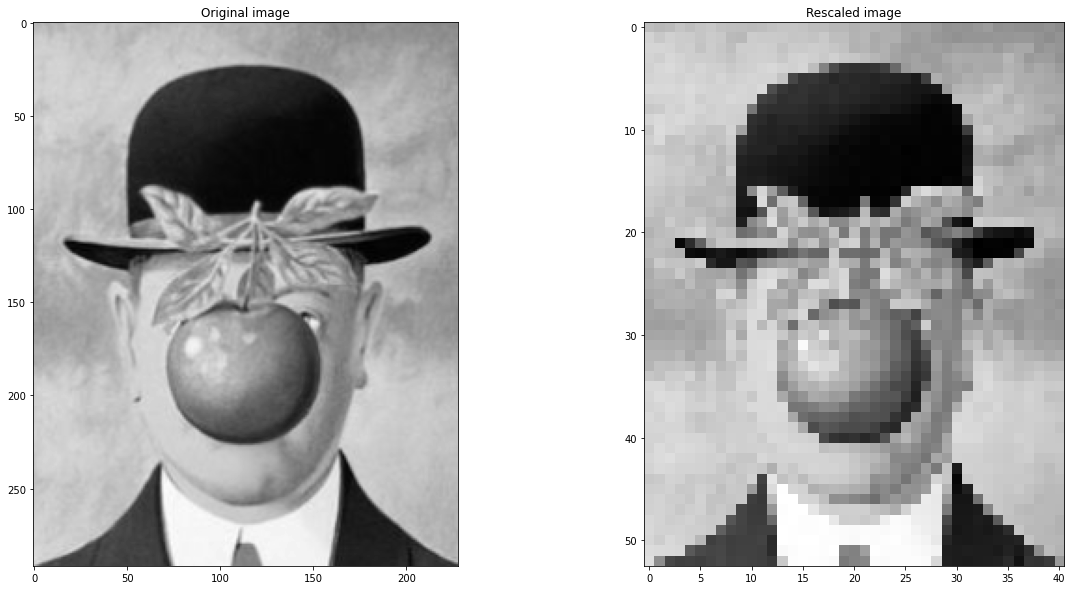

In [ ]:
# import image and rescale 

img_path = '/content/drive/MyDrive/AMATH/SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)
# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)
print("Rescaled size: ", img.shape)
ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

# Functions

In [ ]:
# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):
  '''
  STEP 1A
  '''
  # input : Nx number of columns of image 
  #         Ny number of rows of image 
  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()
  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')
  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')
  D = np.kron(Dy, Dx)
  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):
  '''
  STEP 1A
  '''
  # input : Nx number of columns of image 
  #         Ny number of rows of image 
  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')
  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')
  D = np.kron(Dy, Dx)
  return D

def display_dct(image, dct):
  '''
  STEP 1B
  takes in resized image, and the dct matrix that it corresponds to
  suggestions from Katherine OHs
  '''
  # Vectorize image using img
  dct_flat = image.flatten()
  # Matrix-vector multiply D and vectorized version of image to get DCT. Remember to use np.dot()
  dct_im = np.dot(dct, dct_flat)
  # Make a plot of DCT. These are the coefficients needed to construct the image from cosines of different frequencies
  sns.set_context('talk')
  plt.figure(figsize=(8,6))
  plt.title('DCTs'); plt.xlabel('dct #'), plt.ylabel('cosine frequencies')

  return plt.plot(dct_im)

def display_recons(dct, idct, recon, t):
  """
  STEP 1C
  Displays an image using the methods of the 'matplotlib' library.
  takes in the flattened dct matrix, the idct matrix, an empty image for reconstruction, and thresholds
  """
  # adopted from https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html
  for x, i in enumerate(t):
  #Take the absolute value for threshold and sort coefficients by size.
    th = np.percentile(dct, 100 * (1 - i)); p = np.where(np.abs(dct) >= th, dct, 0)
  # Reconstruct image by multiplying D-1 by the thresheld DCT
    recon[x,:] = np.dot(idct, p) 
  # plot them
  sns.set_context('talk')
  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,10))
  for i in range(len(t)):
    ax[i].imshow(recon[i,:].reshape(53,41),cmap='gray')
    ax[i].set_title("%.1f%% of the \n DCT coefficients" % (t[i]*100))
    ax[i].axis('off')

def B_(M, N):
  '''
  STEP 2A-B
   The dimensions of B will be MxN where M is the number of points measured, 
   and N is the number of pixels in the image. Each row of B has a 1 in the column 
   that corresponds to the pixel which is being sampled, so this will be a sparse matrix
  '''
  # based on Katherine's OH notes and Lec25 notes
  N = np.eye(N) # take the identity matrix of N
  prm = np.random.permutation(N) #randomly selecting 𝑀 rows of the identity matrix
  B = prm[0:M, :].copy() # create B matrix
  return B

def optimize_F(flattened_image, M, N, idct):
  '''
  STEP 2C
  Generate your measurements by matrix-vector multiplying B with the flattened image.
  use matrix multiplication and use the hint about settings for cvx. 
  You will define the variable you are minimizing, x,  the objective function, and the
  constraint. 
  # https://www.cvxpy.org/tutorial/advanced/index.html
  '''
  # adapted from https://inst.eecs.berkeley.edu/~ee123/sp16/hw/hw9_Compressed_Sensing.html
  B_mat = B_(M,N) # creates B matrix from function
  y = np.dot(B_mat , _flat) # B x the flattened image of the dct
  A = np.dot(B_mat, idct) # defines A mtrix
  x = cvx.Variable(N) # optimization variable
  objective = cvx.Minimize(cvx.norm(x,1)) # our objective function
  constraint =  [A @ x == y] # subject to
  problem = cvx.Problem(objective, constraint) # constructs problem
  x_star = problem.solve(verbose=True, solver = 'CVXOPT', max_iter= 1000,  #solve
                    reltol=1e-2, featol= 1e-2)
  ans = np.dot(idct, x.value) # gives values
  return ans

def recov_image_processing(_flat, M, N, idct):
  # takes 30 mins
  '''
  STEP 2D
  '''
  recov = np.empty((9, 2173)); ran = 3 ; index = 0 #sets an empty array for opts, creates runs, and indexes
  for m in M: # three values of M (.2,.4,.6)
    for run in range(ran): # creates 9 images, 3 rows of 3 images
      recov[index, :] = optimize_F(_flat, m, N, idct) # optimize using function
      index += 1
  return recov # returns a mrtixs for each flattened optimized image

def image_recov_mat(n, recovered_image):
  '''
  Plot STEP 2C
  '''
  fig , ax = plt.subplots(n,n, figsize=(20,20))
  index = 0
  for i in range(n):
    for j in range(n):
      # To see how the image reconstruction performed, 
      # reshape the product of D-1 times x* to the image dimension
      ax[i][j].imshow(recovered_image[index, :].reshape(53,41), cmap='gray')
      ax[i][j].axis('off')
      index +=1
  return plt.tight_layout()

def approximate_unknown_plot(B, idct_un, N, y):
  '''
  STEP 3
  Does approximate_F() but on the unknown image and plots the result
  takes in B matrix within the loaded image, the idct for the dimensions of the unknown
  the N (50 x 50), and the y defined ny the loaded image as well
  '''
  A = np.dot(B, idct_un)
  x = cvx.Variable(N)
  objective = cvx.Minimize(cvx.norm(x,1))
  constraint = [A @ x == y]
  problem = cvx.Problem(objective, constraint)
  x_star = problem.solve(verbose=True, solver = 'CVXOPT', max_iter= 1000, 
                         reltol=1e-2, featol= 1e-2)
  ans = np.dot(idct_un, x.value)
  plt.imshow(ans.reshape(50,50), cmap='gray')
  return plt.show()


# Image compression

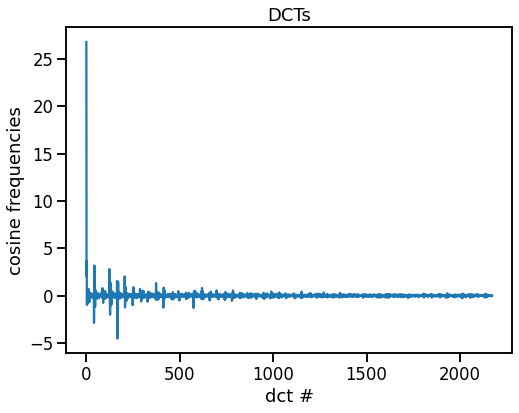

In [ ]:
#construct dct
ny, nx = img.shape
dct = construct_DCT_Mat(nx, ny)
idct = construct_iDCT_Mat(nx, ny)
display_dct(img, dct)

# Thresholding

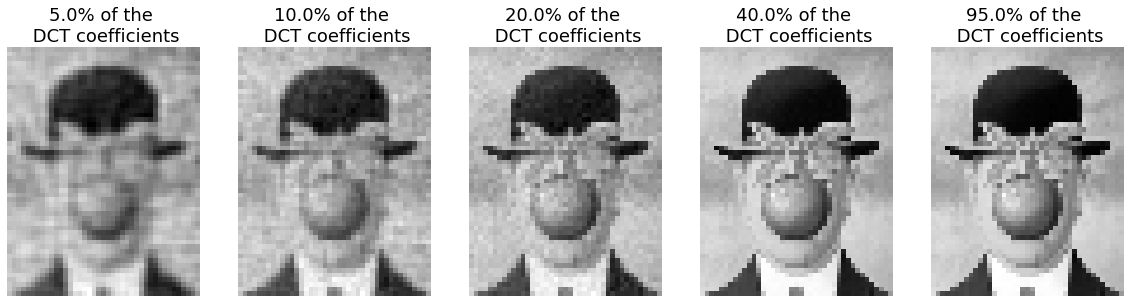

In [ ]:
# Threshold to the first 5, 10, 20, 40% of the coefficients:
recon = np.empty((5,2173))
threshs = [0.05, 0.1, 0.2, 0.4, 0.95] #5.1%, 10.5 %, 20.6%, 40.1%, 95%
_flat = img.flatten()
dct_im = np.dot(dct, _flat)
display_recons(dct_im, idct, recon, threshs)

# Compressed Image Recovery on the Son of Man

In [ ]:
#STEP 2D
N = len(_flat); r = [0.2,0.4,0.6]; M = [math.ceil(i * N) for i in r]

recovered_im = recov_image_processing(_flat, M, N, idct)
# PLOTTED STEP 2D
image_recov_mat(3,recovered_im)

# Unknown image approximation

In [ ]:
unknown = np.load('/content/drive/MyDrive/AMATH/UnknownImage.npz')
B = unknown['B']; y = unknown['y']; idct_unknown = construct_iDCT_Mat(50,50)

approximate_unknown_plot(B, idct_unknown, 2500, y=y)